Loading Data...

Preparing Training Data (Enriched)...
  - Extracting linguistic features...
  - Extracting game move features...
Preparing Validation Data (Enriched)...
  - Extracting linguistic features...
  - Extracting game move features...
Preparing Test Data (Enriched)...
  - Extracting linguistic features...
  - Extracting game move features...

Training MLP Classifier on Enriched Features Only...

--- TEST RESULTS (Enriched Data Only) ---
              precision    recall  f1-score   support

       Truth       0.91      0.97      0.94      2501
   Deception       0.08      0.03      0.04       240

    accuracy                           0.89      2741
   macro avg       0.50      0.50      0.49      2741
weighted avg       0.84      0.89      0.86      2741



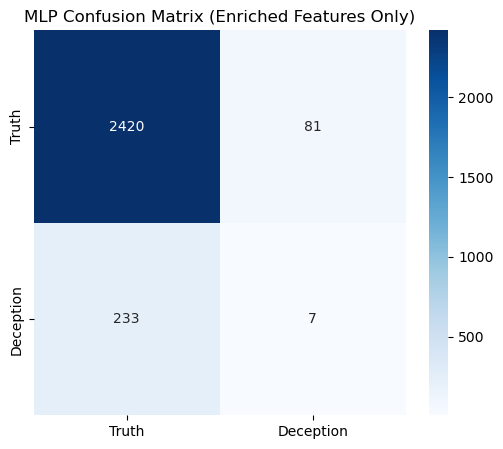

In [3]:
import pandas as pd
import numpy as np
import os
import json
import re
from textblob import TextBlob
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. PATH SETUP
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
data_path = os.path.join(base_path, "data", "processed", "diplomacy")
moves_path = os.path.join(base_path, "data", "raw", "2020_acl_diplomacy", "moves")

# 2. LOAD DATA
print("Loading Data...")
train_df = pd.read_parquet(os.path.join(data_path, "train_processed.parquet"))
val_df = pd.read_parquet(os.path.join(data_path, "val_processed.parquet"))
test_df = pd.read_parquet(os.path.join(data_path, "test_processed.parquet"))

# 3. FEATURE ENGINEERING FUNCTION (Enriched Only)
def extract_features(df):
    df_feat = df.copy()
    
    # Linguistic Features
    print("  - Extracting linguistic features...")
    df_feat['sentiment_polarity'] = df_feat['message_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df_feat['sentiment_subjectivity'] = df_feat['message_text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    df_feat['n_question_marks'] = df_feat['message_text'].apply(lambda x: str(x).count('?'))
    df_feat['n_exclamation_marks'] = df_feat['message_text'].apply(lambda x: str(x).count('!'))
    df_feat['n_i_pronouns'] = df_feat['message_text'].apply(lambda x: len(re.findall(r'\b(i|my|mine|me)\b', str(x).lower())))
    df_feat['n_we_pronouns'] = df_feat['message_text'].apply(lambda x: len(re.findall(r'\b(we|our|ours|us)\b', str(x).lower())))
    df_feat['word_count'] = df_feat['message_text'].apply(lambda x: len(str(x).split()))
    
    # Game Move Features
    print("  - Extracting game move features...")
    def get_move_stats(row):
        filename = f"DiplomacyGame{row['game_id']}_{row['year']}_{row['season'].lower()}.json"
        file_path = os.path.join(moves_path, filename)
        stats = {'n_orders': 0, 'n_support': 0, 'n_hold': 0, 'n_move_fails': 0}
        
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                speaker_country = str(row['speaker']).capitalize()
                if 'orders' in data and speaker_country in data['orders']:
                    orders = data['orders'][speaker_country]
                    stats['n_orders'] = len(orders)
                    for order in orders.values():
                        if 'SUPPORT' in order.get('type', ''): stats['n_support'] += 1
                        if 'HOLD' in order.get('type', ''): stats['n_hold'] += 1
                        if 'FAILS' in order.get('result', ''): stats['n_move_fails'] += 1
            except: pass
        return pd.Series(stats)

    move_feats = df_feat.apply(get_move_stats, axis=1)
    df_feat = pd.concat([df_feat, move_feats], axis=1)
    
    # Drop non-feature columns
    features_to_keep = ['sentiment_polarity', 'sentiment_subjectivity', 'n_question_marks', 
                        'n_exclamation_marks', 'n_i_pronouns', 'n_we_pronouns', 'word_count',
                        'n_orders', 'n_support', 'n_hold', 'n_move_fails']
    
    return df_feat[features_to_keep], df['target']

# 4. PREPARE DATASETS
print("\nPreparing Training Data (Enriched)...")
X_train, y_train = extract_features(train_df)
print("Preparing Validation Data (Enriched)...")
X_val, y_val = extract_features(val_df)
print("Preparing Test Data (Enriched)...")
X_test, y_test = extract_features(test_df)

# 5. SCALE FEATURES
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 6. TRAIN MLP MODEL
print("\nTraining MLP Classifier on Enriched Features Only...")
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', 
                    alpha=0.0001, batch_size='auto', learning_rate='adaptive', 
                    learning_rate_init=0.001, max_iter=200, random_state=42, early_stopping=True)

mlp.fit(X_train_scaled, y_train)

# 7. EVALUATE
print("\n--- TEST RESULTS (Enriched Data Only) ---")
y_pred = mlp.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=['Truth', 'Deception']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Truth', 'Deception'], yticklabels=['Truth', 'Deception'])
plt.title('MLP Confusion Matrix (Enriched Features Only)')
plt.show()

We also evaluated the MLPClassifier on the enriched dataset, but it did not yield significant performance improvements.